Loaded Xception base.


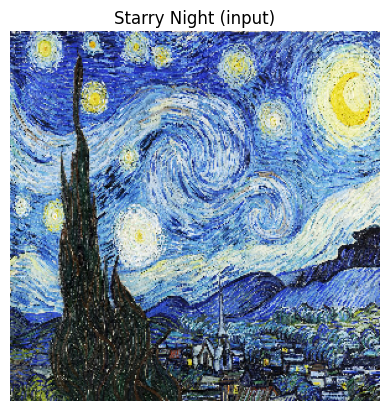

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


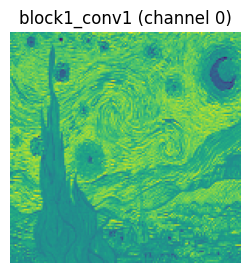

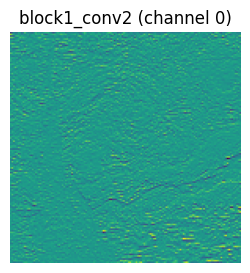

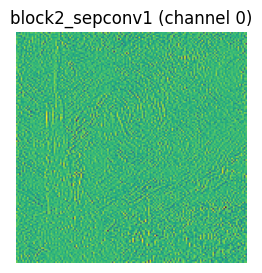

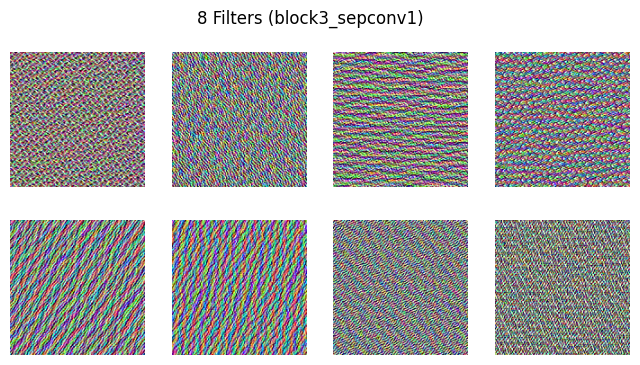

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[('n01917289', 'brain_coral', np.float32(0.21833216)), ('n03998194', 'prayer_rug', np.float32(0.10592198)), ('n09256479', 'coral_reef', np.float32(0.10186985))]


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_933']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


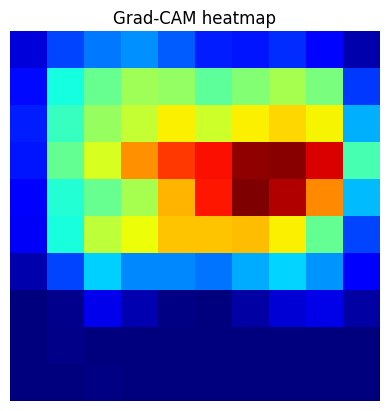

In [4]:
# ===========================================
#  Xception + starry_night.jpg 軽量版
#  - 中間層可視化：最初の3層 × 1チャンネル
#  - フィルタ可視化：最初の8フィルタのみ
#  - Grad-CAM：1枚のみ
# ===========================================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.cm as cm

# -------------------------------
# 0. Xception base
# -------------------------------
base_model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)
print("Loaded Xception base.")

# -------------------------------
# 1. starry_night.jpg (only)
# -------------------------------
style_image_path = keras.utils.get_file(
    "starry_night.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg"
)

def load_img_raw(path, size=(299, 299)):
    img = keras.utils.load_img(path, target_size=size)
    return keras.utils.img_to_array(img)

def preprocess_xception(path, size=(299, 299)):
    img = keras.utils.load_img(path, target_size=size)
    arr = keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, 0)
    return keras.applications.xception.preprocess_input(arr)

img_raw = load_img_raw(style_image_path)
img_batch = preprocess_xception(style_image_path)

plt.figure()
plt.axis("off")
plt.title("Starry Night (input)")
plt.imshow(img_raw.astype("uint8"))
plt.show()

# -------------------------------
# 2. 中間層可視化（最初の3層のみ）
# -------------------------------
layer_outputs = []
layer_names = []

for layer in base_model.layers[:50]:  # 50層だけ見る（安全）
    if isinstance(layer, (layers.Conv2D,
                          layers.SeparableConv2D,
                          layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# 最初の3層に限定
layer_outputs = layer_outputs[:3]
layer_names = layer_names[:3]

activation_model = keras.Model(base_model.inputs, layer_outputs)
activations = activation_model.predict(img_batch)

for name, act in zip(layer_names, activations):
    plt.figure(figsize=(3, 3))
    plt.title(f"{name} (channel 0)")
    plt.axis("off")
    plt.imshow(act[0, :, :, 0], cmap="viridis")
    plt.show()

# -------------------------------
# 3. フィルタ可視化（8個だけ）
# -------------------------------
layer_name = "block3_sepconv1"
target_layer = base_model.get_layer(layer_name)
feature_extractor = keras.Model(base_model.input, target_layer.output)

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    fa = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(fa)

@tf.function
def gradient_ascent_step(image, idx, lr=10.0):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, idx)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += lr * grads
    return image

def generate_filter(idx, steps=20):
    img = tf.random.uniform((1, 200, 200, 3), 0.4, 0.6)
    for _ in range(steps):
        img = gradient_ascent_step(img, idx)
    return img[0].numpy()

def deprocess(img):
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img = img * 64 + 128
    img = np.clip(img, 0, 255).astype("uint8")
    return img[25:-25, 25:-25]

# 最初の8フィルタのみ
patterns = [deprocess(generate_filter(i)) for i in range(8)]

# 2x4 グリッド表示
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
fig.suptitle("8 Filters (block3_sepconv1)")
for ax, img in zip(axes.flat, patterns):
    ax.imshow(img)
    ax.axis("off")
plt.show()

# -------------------------------
# 4. Grad-CAM（1枚だけ）
# -------------------------------
full_model = keras.applications.xception.Xception(weights="imagenet")

def preprocess_full(path):
    img = keras.utils.load_img(path, target_size=(299, 299))
    arr = keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, 0)
    return keras.applications.xception.preprocess_input(arr)

arr = preprocess_full(style_image_path)
preds = full_model.predict(arr)
top_idx = np.argmax(preds[0])
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

grad_layer = full_model.get_layer("block14_sepconv2_act")
grad_model = keras.Model(full_model.inputs, grad_layer.output)

cls_model = keras.Model(
    grad_layer.output,
    full_model.get_layer("predictions").output
)

with tf.GradientTape() as tape:
    conv_out = grad_model(arr)
    tape.watch(conv_out)
    preds_cls = cls_model(conv_out)
    target = preds_cls[:, top_idx]

grads = tape.gradient(target, conv_out)
weights = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

conv_out = conv_out.numpy()[0]
for i in range(weights.shape[0]):
    conv_out[:, :, i] *= weights[i]

heatmap = np.mean(conv_out, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= (heatmap.max() + 1e-8)

plt.figure()
plt.title("Grad-CAM heatmap")
plt.axis("off")
plt.imshow(heatmap, cmap="jet")
plt.show()
